In [1]:
# import lib
import cv2
import numpy as np
import os
import h5py
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

In [2]:
data_dir = 'input'

In [3]:
class_labels = os.listdir(data_dir)
print(class_labels)

['MASK', 'MOUTH_BELOW', 'NO MASK', 'NOSE_BELOW']


In [4]:
nb_sampl = 0
for label in os.listdir('input'):
    total = len(os.listdir(os.path.join('input', label)))
    print(label, total)
    nb_sampl+=total

MASK 2374
MOUTH_BELOW 1275
NO MASK 2746
NOSE_BELOW 2890


In [5]:
num_classes = len(class_labels)
img_rows= 64       #to reduce resolution.. tuning
img_cols= 64
channel = 3

In [6]:
num_classes

4

In [7]:
#Data Preprocessing using opencv
def load_data():
    #Load training images
    labels = class_labels
    print(labels)
    total = len(labels)
    
    X_train = np.ndarray((nb_sampl, img_rows, img_cols, channel), dtype = np.uint8)
    Y_train = np.zeros((nb_sampl,), dtype = np.uint8)
    
    i = 0
    j = 0
    for label in labels:
        image_names_train = os.listdir(os.path.join(data_dir, label))
        total = len(image_names_train)
        print(label, total)
        for image_name in image_names_train:
            try: 
                img = cv2.imread(os.path.join(data_dir, label, image_name), 1)
                img = np.array(cv2.resize(img, (img_rows,img_cols)))
                X_train[i] = img
                Y_train[i] = j
            except Exception as e:
                pass
            i += 1
        j += 1      
    Y_train = np_utils.to_categorical(Y_train[:nb_sampl], num_classes)
    return X_train, Y_train

In [8]:
#calling the preprocessing function
X, Y = load_data()

['MASK', 'MOUTH_BELOW', 'NO MASK', 'NOSE_BELOW']
MASK 2374
MOUTH_BELOW 1275
NO MASK 2746
NOSE_BELOW 2890


In [9]:
print(X.shape, Y.shape)

(9285, 64, 64, 3) (9285, 4)


In [10]:
# normalize data
X = X.astype('float32')
X /= 255

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=44, test_size=0.2)

In [12]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False

In [13]:
#Combining VGG16 with the output  layers
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [14]:
#compiling the model
model.compile(
    loss= 'categorical_crossentropy', 
    optimizer=Adam(lr=0.001, decay=1e-04),
    metrics=['accuracy']
)
epochs=3

In [15]:
#checking the models layer flow
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                102450    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 84        
Total params: 14,818,242
Trainable params: 103,554
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
#training the model 
history = model.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=epochs,
    validation_data=(X_test, y_test),
    shuffle=True
)


Epoch 1/3
75/75 [==============================] - 183s 2s/step - loss: 0.9694 - accuracy: 0.5926 - val_loss: 0.5845 - val_accuracy: 0.7787
Epoch 2/3
75/75 [==============================] - 179s 2s/step - loss: 0.5278 - accuracy: 0.7960 - val_loss: 0.4868 - val_accuracy: 0.8072
Epoch 3/3
75/75 [==============================] - 178s 2s/step - loss: 0.3777 - accuracy: 0.8658 - val_loss: 0.4495 - val_accuracy: 0.8250


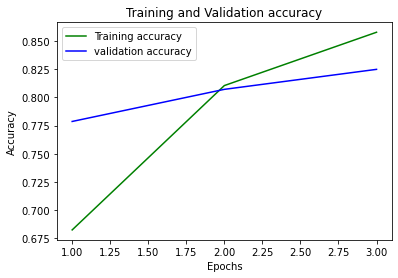

In [17]:
#visualizing the training accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs1 = range(1,epochs+1)
plt.plot(epochs1, loss_train, 'g', label='Training accuracy')
plt.plot(epochs1, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

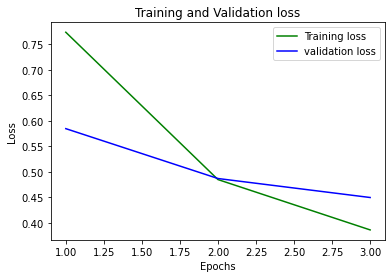

In [18]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.plot(epochs1, loss_train, 'g', label='Training loss')
plt.plot(epochs1, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
#testing the test data
y_pred = model.predict(X_test, batch_size=10, verbose=0)

y_predict = []
for i in range(0, len(y_pred)):
    y_predict.append(int(np.argmax(y_pred[i])))
len(y_predict)

y_true = []
for i in range(0, len(y_test)):
    y_true.append(int(np.argmax(y_test[i])))
len(y_true)

1857

In [20]:
#function for ploting attractive confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm_plot_labels = class_labels

In [21]:
# statistical output for test data
print(classification_report(y_true=y_true,y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       478
           1       0.76      0.62      0.68       249
           2       0.82      0.95      0.88       561
           3       0.83      0.82      0.83       569

    accuracy                           0.82      1857
   macro avg       0.82      0.80      0.80      1857
weighted avg       0.82      0.82      0.82      1857



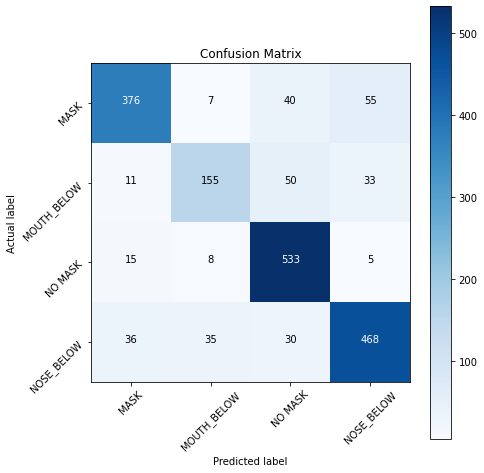

In [22]:
# to plot confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_predict)
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [23]:
#Evaluating the models overall accuracy and loss
score = model.evaluate(x= X_test, y= y_test, batch_size=32)
print("Loss Value : ", score[0])
print("Accuracy : ", score[1])

59/59 [==============================] - 37s 622ms/step - loss: 0.4495 - accuracy: 0.8250
Loss Value :  0.44953155517578125
Accuracy :  0.8249865174293518


In [24]:
#Saving the trained model for reusability
model_structure = model.to_json()
f = Path("model/vgg_model_structure.json")
f.write_text(model_structure)

model.save_weights("model/vgg_model_weights.h5")